In [1]:
import pandas as pd
import numpy as np
import datetime
from importlib import reload
import scipy.sparse as spa
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
# full_data = pd.read_csv("yellow_tripdata_2010-01.csv")
# full_data['pickup_datetime'] = pd.to_datetime(full_data['pickup_datetime'])
# full_data['dropoff_datetime'] = pd.to_datetime(full_data['dropoff_datetime'])

In [3]:
year = 2010
month = 1
day = 21
date = datetime.date(year, month, day)

In [4]:
# day_data = full_data.loc[(full_data['pickup_datetime'].dt.date == date) & (full_data['dropoff_datetime'].dt.date == date)]
# day_data = day_data[['pickup_datetime', 'dropoff_datetime', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'surcharge', 'mta_tax', 'tip_amount', 'tolls_amount', 'total_amount']]
# day_data = day_data.loc[(day_data['pickup_longitude'] != 0) & (day_data['pickup_latitude'] != 0)]
# day_data.to_csv(r'yellow_tripdata_2010-01-21.csv', index=False)

In [5]:
day_data = pd.read_csv("yellow_tripdata_2010-01-21.csv")
day_data['pickup_datetime'] = pd.to_datetime(day_data['pickup_datetime'])
day_data['dropoff_datetime'] = pd.to_datetime(day_data['dropoff_datetime'])

In [6]:
n = 100
data = day_data.sample(n).sort_values(by='pickup_datetime')
data.index = range(n)

# Time Window MIO Formulation

In [7]:
import class_TP
reload(class_TP)
from class_TP import TP

time_windows = [1, 5, 10]
obj_val = []
runtimes = []

tp = TP(data)
for time_window in time_windows:
    x, problem = tp.problem_window(time_window)
    
    sims = 1
    runtime = 0
    for i in range(sims):
        problem.solve(solver=cp.GUROBI, TimeLimit = 300)
        # solver=cp.MOSEK, mosek_params = {mosek.dparam.optimizer_max_time:  1.0}
        runtime += problem.solver_stats.solve_time
    runtimes.append(runtime/sims)
    obj_val.append(problem.objective.value)
    
    print("Time Window:", time_window)
    print("Run Time:", problem.solver_stats.solve_time)
    print("Objective Value:", problem.objective.value)
    x_val = spa.dok_matrix((tp.num_nodes, tp.num_nodes))
    for a in range(tp.num_arcs):
        x_val[tp.arcs[a]] = np.around(x[a].value, decimals=2)
    print(x_val.tocoo())

Academic license - for non-commercial use only - expires 2021-05-21
Using license file C:\Users\holly\gurobi.lic
Time Window: 1
Run Time: 0.06421279907226562
Objective Value: -651.6739860048415
  (1, 4)	1.0
  (100, 1)	1.0
  (2, 3)	1.0
  (100, 2)	1.0
  (3, 6)	1.0
  (4, 7)	1.0
  (6, 11)	1.0
  (7, 8)	1.0
  (8, 10)	1.0
  (10, 12)	1.0
  (11, 13)	1.0
  (12, 14)	1.0
  (13, 16)	1.0
  (14, 15)	1.0
  (15, 17)	1.0
  (16, 20)	1.0
  (17, 19)	1.0
  (19, 22)	1.0
  (20, 23)	1.0
  (22, 24)	1.0
  (23, 25)	1.0
  (24, 26)	1.0
  (25, 27)	1.0
  (26, 28)	1.0
  (27, 33)	1.0
  :	:
  (60, 64)	1.0
  (61, 62)	1.0
  (62, 66)	1.0
  (64, 65)	1.0
  (65, 68)	1.0
  (66, 73)	1.0
  (68, 72)	1.0
  (72, 76)	1.0
  (73, 77)	1.0
  (76, 78)	1.0
  (77, 79)	1.0
  (78, 81)	1.0
  (79, 85)	1.0
  (81, 83)	1.0
  (83, 86)	1.0
  (85, 87)	1.0
  (86, 88)	1.0
  (87, 90)	1.0
  (88, 93)	1.0
  (90, 91)	1.0
  (91, 96)	1.0
  (93, 95)	1.0
  (95, 99)	1.0
  (96, 101)	1.0
  (99, 101)	1.0
Time Window: 5
Run Time: 0.09400367736816406
Objective Value

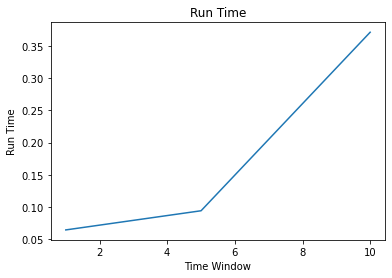

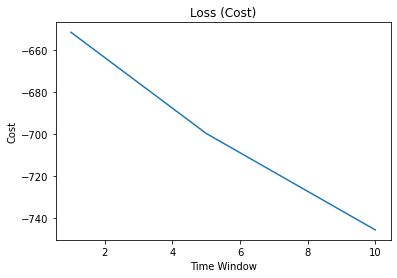

In [8]:
plt.figure(1)
plt.plot(time_windows, runtimes);
plt.title("Run Time");
plt.xlabel("Time Window");
plt.ylabel("Run Time");
plt.figure(2)
plt.plot(time_windows, obj_val);
plt.title("Loss (Cost)");
plt.xlabel("Time Window");
plt.ylabel("Cost");

# Gradient Descent

In [9]:
import class_TP
reload(class_TP)
from class_TP import TP

tp = TP(data)
window = 10
t, x, problem = tp.problem_param()
t_min, t_max = tp.time_cons(window)
_,_,_,p = tp.flow_vars()
t.value = [(a + b) / 2.0 for a, b in zip(t_min, t_max)] # midpoint of time window
t_hist = []
loss_hist = []
runtime_hist = []

learn_rate = .1
for i in range(1000):
    if (i > 9 and np.abs(loss_hist[-2] - loss_hist[-1]) < .01):
        print("Descent converged in %d iterations" % (i+1))
        break
#     acceleration_lookback=10, eps=1e-03, max_iters=1000
    problem.solve(requires_grad=True, solver=cp.DIFFCP, solve_method="ECOS")
    x.gradient = -p
    problem.backward()
    t.value -= learn_rate * t.gradient
    t.value = np.minimum(np.maximum(t.value, t_min), t_max)
    
    t_hist.append(t.value)
    loss_hist.append(problem.objective.value)
    runtime_hist.append(problem.solver_stats.solve_time)

    print("Iteration", i+1)
    print("Objective Value:", problem.objective.value)
    print("Run Time:", problem.solver_stats.solve_time)

Iteration 1
Objective Value: -637.9820857467699
Run Time: 0.1792167
Iteration 2
Objective Value: -646.0160789516631
Run Time: 0.1879289
Iteration 3
Objective Value: -646.4649847944139
Run Time: 0.1962551
Iteration 4
Objective Value: -651.7399139148126
Run Time: 0.2105205
Iteration 5
Objective Value: -651.7399139146856
Run Time: 0.1873902
Iteration 6
Objective Value: -667.264109644371
Run Time: 0.1926448
Iteration 7
Objective Value: -666.555429273142
Run Time: 0.1852458
Iteration 8
Objective Value: -662.3881578157904
Run Time: 0.1973047
Iteration 9
Objective Value: -664.170015819243
Run Time: 0.1934905
Iteration 10
Objective Value: -665.7782651915966
Run Time: 0.2035183
Iteration 11
Objective Value: -665.7782651916002
Run Time: 0.1994333
Descent converged in 12 iterations


In [10]:
full_time = sum(runtime_hist)
print("Time:", full_time)
print("Loss (Cost):", np.amin(loss_hist))

# x_val = spa.dok_matrix((tp.num_nodes, tp.num_nodes))
# for a in range(tp.num_arcs):
#     x_val[tp.arcs[a]] = np.around(x[a].value, decimals=2)
# print(x_val.tocoo())

Time: 2.1329488
Loss (Cost): -667.264109644371
  (1, 4)	1.0
  (100, 1)	1.0
  (2, 5)	1.0
  (100, 2)	1.0
  (4, 6)	1.0
  (5, 7)	1.0
  (6, 11)	1.0
  (7, 8)	1.0
  (8, 10)	1.0
  (10, 12)	1.0
  (11, 13)	1.0
  (12, 14)	1.0
  (13, 16)	1.0
  (14, 15)	1.0
  (15, 17)	1.0
  (16, 20)	1.0
  (17, 19)	1.0
  (19, 21)	1.0
  (20, 23)	1.0
  (21, 25)	1.0
  (23, 24)	1.0
  (24, 28)	1.0
  (25, 27)	1.0
  (27, 33)	1.0
  (28, 31)	1.0
  :	:
  (59, 61)	1.0
  (60, 63)	1.0
  (61, 62)	1.0
  (62, 66)	1.0
  (63, 65)	1.0
  (65, 75)	1.0
  (66, 72)	1.0
  (72, 76)	1.0
  (75, 78)	1.0
  (76, 77)	1.0
  (77, 79)	1.0
  (78, 81)	1.0
  (79, 85)	1.0
  (81, 83)	1.0
  (83, 86)	1.0
  (85, 87)	1.0
  (86, 88)	1.0
  (87, 90)	1.0
  (88, 93)	1.0
  (90, 91)	1.0
  (91, 96)	1.0
  (93, 95)	1.0
  (95, 99)	1.0
  (96, 101)	1.0
  (99, 101)	1.0


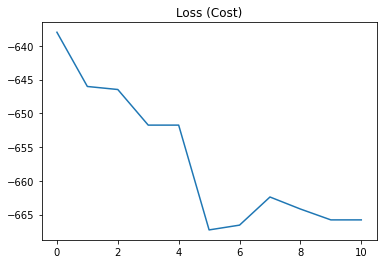

In [11]:
plt.figure(1)
plt.plot(loss_hist);
plt.title("Loss (Cost)");
plt.xlabel("Iteration");
plt.ylabel("Cost");

## ...starting from 10 uniformly random time points between t_min and t_max

In [16]:
import class_TP
reload(class_TP)
from class_TP import TP

tp = TP(data)
window = 10
t, x, problem = tp.problem_param()
t_min, t_max = tp.time_cons(window)
_,_,_,p = tp.flow_vars()
loss_lines = []
runtime_lines = []
full_times = []

learn_rate = .1
max_iter = 0
for s in range(10):
    # Start from 10 different points of t.value between t_min and t_max (randomly drawn from uniform)
    print("Random Starting Point", s+1)
    t.value = [np.random.uniform(a, b) for a, b in zip(t_min, t_max)]
    t_hist = []
    loss_hist = []
    runtime_hist = []
    for i in range(1000):
        if (i > 9 and np.abs(loss_hist[-2] - loss_hist[-1]) < .01):
            print("Descent converged in %d iterations" % (i+1))
            if (i > max_iter): max_iter = i
            break
#         acceleration_lookback=10, eps=1e-03, max_iters=1000
        problem.solve(requires_grad=True, solver=cp.DIFFCP, solve_method="ECOS")
        x.gradient = -p
        problem.backward()
        t.value -= learn_rate * t.gradient
        t.value = np.minimum(np.maximum(t.value, t_min), t_max)

        t_hist.append(t.value)
        loss_hist.append(problem.objective.value)
        runtime_hist.append(problem.solver_stats.solve_time)
        
    loss_lines.append(loss_hist)
    runtime_lines.append(runtime_hist)
    full_times.append(sum(runtime_hist))
    print("Time:", full_times[-1])
    print("Loss (Cost):", np.amin(loss_hist))
    print()

Random Starting Point 1
Descent converged in 11 iterations
Time: 1.5214076
Loss (Cost): -664.3917336347953
Random Starting Point 2
Descent converged in 14 iterations
Time: 2.7686008
Loss (Cost): -655.0895115194089
Random Starting Point 3
Descent converged in 11 iterations
Time: 2.1979439
Loss (Cost): -661.8843268190358
Random Starting Point 4
Descent converged in 13 iterations
Time: 2.4327751
Loss (Cost): -662.7217611932273
Random Starting Point 5
Descent converged in 11 iterations
Time: 1.9652424
Loss (Cost): -657.8635839427384
Random Starting Point 6
Descent converged in 13 iterations
Time: 2.3350602
Loss (Cost): -663.863974868433
Random Starting Point 7
Descent converged in 12 iterations
Time: 1.9103174999999997
Loss (Cost): -671.613507828868
Random Starting Point 8
Descent converged in 13 iterations
Time: 2.5997768999999997
Loss (Cost): -657.8145670438737
Random Starting Point 9
Descent converged in 11 iterations
Time: 2.0465076
Loss (Cost): -659.3360415125549
Random Starting Point

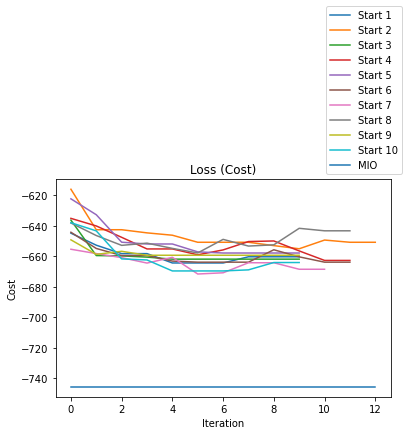

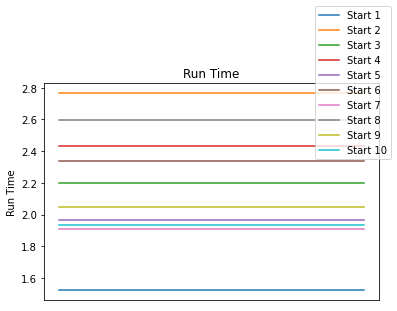

In [28]:
for i in range(len(loss_lines)):
    plt.plot(loss_lines[i], label = 'Start %s'%(i+1))
plt.plot([obj_val[time_windows.index(window)]]*max_iter, label = 'MIO')
plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right', ncol=1)
plt.title("Loss (Cost)")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

for i in range(len(runtime_lines)):
    plt.plot([full_times[i]]*2, label = 'Start %s'%(i+1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='right', ncol=1)
plt.title("Run Time")
plt.xticks([])
plt.ylabel("Run Time")
plt.show()

## ...with Line Search

In [29]:
def f(t_sol, problem, t):
    t.value = t_sol
    problem.solve(requires_grad=True, solver=cp.DIFFCP, solve_method="ECOS")
    return problem.objective.value

def df(t_sol, problem, t):
    x.gradient = -p
    problem.backward()
    return t.gradient

def line_search(t_sol, dt, problem, t, alpha=0.4, beta=0.9):
    r = 1
    f_t = f(t_sol, problem, t)
    df_t = df(t_sol, problem, t)
    for k in range(10):
#         proj_t = np.minimum(np.maximum(t_sol + r * dt, t_min), t_max)
        f_next = f(t_sol + r * dt, problem, t)
        f_extrap = f_t - alpha * r * df_t.T.dot(dt)
        if f_next <= f_extrap:
            return r
        r *= beta
    print("Max iterations hit in line search")
    return 0

In [30]:
import class_TP
reload(class_TP)
from class_TP import TP

tp = TP(data)
window = 10
t, x, problem = tp.problem_param()
t_min, t_max = tp.time_cons(window)
_,_,_,p = tp.flow_vars()
t.value = [(a + b) / 2.0 for a, b in zip(t_min, t_max)]
t_hist = []
loss_hist = []
runtime_hist = []

problem.solve(requires_grad=True, solver=cp.DIFFCP, solve_method="ECOS")
t_sol = t.value
for i in range(100):
    if (i > 1 and np.abs(loss_hist[-2] - loss_hist[-1]) < .01):
        print("Descent converged in %d iterations" % (i+1))
        break
    dt = -df(t_sol, problem, t)
    r = line_search(t_sol, dt, problem, t)
    t_sol = np.minimum(np.maximum(t_sol + r * dt, t_min), t_max)
    
    t_hist.append(t_sol)
    loss_hist.append(problem.objective.value)
    runtime_hist.append(problem.solver_stats.solve_time)

    print("Iteration", i+1)
    print("Objective Value:", problem.objective.value)
    print("Runt Time:", problem.solver_stats.solve_time)

Iteration 1
Objective Value: -647.7175550626816
Runt Time: 0.0800536
Iteration 2
Objective Value: -654.1529528075256
Runt Time: 0.1065657
Iteration 3
Objective Value: -645.8349984992158
Runt Time: 0.118025
Iteration 4
Objective Value: -658.0315620432509
Runt Time: 0.1942581
Iteration 5
Objective Value: -663.7260581170308
Runt Time: 0.1385784
Iteration 6
Objective Value: -675.2827417387554
Runt Time: 0.1196193
Iteration 7
Objective Value: -666.0135354346728
Runt Time: 0.1189827
Iteration 8
Objective Value: -668.4667936370122
Runt Time: 0.1902312
Iteration 9
Objective Value: -643.4337831060052
Runt Time: 0.1391106
Iteration 10
Objective Value: -654.4665187859039
Runt Time: 0.1492464
Iteration 11
Objective Value: -666.2771538989009
Runt Time: 0.1137338
Iteration 12
Objective Value: -682.2327334036164
Runt Time: 0.1784807
Iteration 13
Objective Value: -681.020987036699
Runt Time: 0.1043598
Iteration 14
Objective Value: -683.1433725309761
Runt Time: 0.1722238
Iteration 15
Objective Value: -

In [33]:
full_time = sum(runtime_hist)
print("Time:", full_time)
print("Loss (Cost):", np.amin(loss_hist))

# x_val = spa.dok_matrix((tp.num_nodes, tp.num_nodes))
# for a in range(tp.num_arcs):
#     x_val[tp.arcs[a]] = np.around(x[a].value, decimals=2)
# print(x_val.tocoo())

Time: 14.047576600000005
Loss (Cost): -698.0712052266434


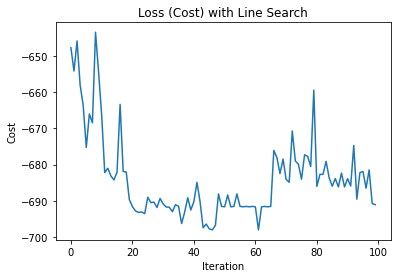

In [35]:
plt.figure(1)
plt.plot(loss_hist);
plt.title("Loss (Cost) with Line Search");
plt.xlabel("Iteration");
plt.ylabel("Cost");

# Incrementing 2 time parameters and fixing the remainder

In [8]:
import class_TP
reload(class_TP)
from class_TP import TP

tp = TP(data)
window = 0  # fixed at zero
t, x, problem = tp.problem_param(window)
t_min, _ = tp.time_cons(window)
t_vals = t_min[:]

t_range = 20
step = 2
dim = int(t_range/step)
heat_map = np.zeros((dim, dim))
run_times = np.zeros((dim, dim))
t0_vec = np.arange(0, t_range, step)
t1_vec = np.arange(0, t_range, step)
c1 = 15
c2 = 16
for t0_idx in range(len(t0_vec)):
    for t1_idx in range(len(t1_vec)):
        t0 = t0_vec[t0_idx]
        t1 = t1_vec[t1_idx]
        t_vals[c1] = t_min[c1] + t0
        t_vals[c2] = t_min[c2] + t1
        t.value = t_vals
        problem.solve(solver="ECOS")
        obj_val = problem.objective.value
        run_time = problem.solver_stats.solve_time
        heat_map[t0_idx, t1_idx] = obj_val
        run_times[t0_idx, t1_idx] = run_time
        
        print("Run Time:", run_time)
#         print("Objective Value:", obj_val)
#         print(t.value[c1], t.value[c2])

#         x_val = spa.dok_matrix((tp.num_nodes, tp.num_nodes))
#         for a in range(tp.num_arcs):
#             x_val[tp.arcs[a]] = np.around(x[a].value, decimals=2)
#         print(x_val.tocoo())

Run Time: 0.1008728
Run Time: 0.1162375
Run Time: 0.1373452
Run Time: 0.1404041
Run Time: 0.1169746
Run Time: 0.2042596
Run Time: 0.1086392
Run Time: 0.1171832
Run Time: 0.122976
Run Time: 0.1146664
Run Time: 0.1595448
Run Time: 0.1196764
Run Time: 0.1827466
Run Time: 0.1145813
Run Time: 0.1209741
Run Time: 0.1621789
Run Time: 0.1875264
Run Time: 0.1961291
Run Time: 0.1812618
Run Time: 0.2140715
Run Time: 0.174247
Run Time: 0.1909979
Run Time: 0.2008207
Run Time: 0.1677234
Run Time: 0.1727318
Run Time: 0.1026948
Run Time: 0.1101213
Run Time: 0.1097271
Run Time: 0.1608175
Run Time: 0.1451425
Run Time: 0.0906714
Run Time: 0.1762985
Run Time: 0.103102
Run Time: 0.1493531
Run Time: 0.1318923
Run Time: 0.1776844
Run Time: 0.130563
Run Time: 0.1154287
Run Time: 0.2244114
Run Time: 0.1027529
Run Time: 0.1933858
Run Time: 0.1651073
Run Time: 0.198501
Run Time: 0.1177862
Run Time: 0.1935686
Run Time: 0.1891117
Run Time: 0.1920918
Run Time: 0.1105273
Run Time: 0.1064391
Run Time: 0.1740807
Run T

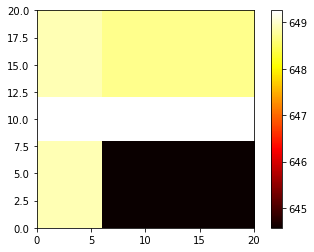

In [9]:
plt.imshow(heat_map, cmap='hot', interpolation='nearest', extent=[0, t_range, 0, t_range])
plt.colorbar()
plt.show()

In [10]:
heat_map

array([[648.90443654, 648.90443654, 648.90443654, 648.72165146,
        648.72165146, 648.72165147, 648.72165147, 648.72165146,
        648.72165147, 648.72165147],
       [648.90443654, 648.90443654, 648.90443654, 648.72165146,
        648.72165146, 648.72165147, 648.72165147, 648.72165146,
        648.72165147, 648.72165147],
       [648.90443654, 648.90443654, 648.90443654, 648.72165146,
        648.72165146, 648.72165147, 648.72165147, 648.72165146,
        648.72165147, 648.72165147],
       [648.90443654, 648.90443654, 648.90443654, 648.72165146,
        648.72165146, 648.72165147, 648.72165147, 648.72165146,
        648.72165147, 648.72165147],
       [649.25943505, 649.25943505, 649.25943505, 649.25943505,
        649.25943505, 649.25943505, 649.25943505, 649.25943505,
        649.25943505, 649.25943505],
       [649.25943505, 649.25943505, 649.25943505, 649.25943505,
        649.25943505, 649.25943505, 649.25943505, 649.25943505,
        649.25943505, 649.25943505],
       [64

In [11]:
# run_seconds = [t / 60 for t in run_times]
# run_seconds

## Map

In [ ]:
import geopandas as gpd
import contextily as ctx

In [ ]:
x_val = spa.dok_matrix((n+taxis+2, n+taxis+2))
for i in range(n+taxis+2):
    for j in s_list[i]:
        x_val[i,j] = x[arcs.get((i,j))].value
print("Time Window:", time_window)
print(x_val.tocoo())
print(objective.value)

In [ ]:
arcs = np.asarray(np.nonzero(x_val))
# locs = np.unique(arcs[arcs < 200])
# lons = data.iloc[locs, 3]
# lats = data.iloc[locs, 4]

loc_origin = arcs[0][:-taxis-2]
loc_destin = arcs[1][:-taxis-2]

lon_origin = data.iloc[loc_origin, 3].to_numpy()
lat_origin = data.iloc[loc_origin, 4].to_numpy()
lon_destin = data.iloc[loc_destin, 3].to_numpy()
lat_destin = data.iloc[loc_destin, 4].to_numpy()

In [ ]:
# from shapely.geometry import Point, LineString
from matplotlib.patches import FancyArrowPatch

nyc = gpd.read_file(gpd.datasets.get_path('nybb'))
# nyc = nyc.to_crs(epsg=3857)
nyc = nyc.to_crs(epsg=4326)
ax = nyc.plot(figsize=(20, 20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

ax.set_xlim(-74.05, -73.85)
ax.set_ylim(40.68, 40.82)

# nodes = gpd.GeoDataFrame(geometry=gpd.points_from_xy(lons, lats))
# nodes.plot(color='green')

fig = plt.figure()

# One Taxi's Journey
taxi_num = n + 1
node = arcs[1][np.where(arcs[0] == taxi_num)] # First node (rider) for given taxi
while True:
    where = np.array(np.where(loc_origin == node))
    if (where.size == 0): break
    i = where[0][0]
    dx = lon_destin[i] - lon_origin[i]
    dy = lat_destin[i] - lat_origin[i]
    ax.arrow(lon_origin[i], lat_origin[i], dx, dy, color = 'pink', width=.0004)
    node = loc_destin[i]

plt.show()